In [1]:
#!unzip dank_data-master.zip
#!pip install tensorflow_addons
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [2]:
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,MaxPool1D,Activation,Dropout,Flatten,Embedding,LSTM,concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
training='/content/dank_data-master/data/training/*'
test='/content/dank_data-master/data/test/*'
validation='/content/dank_data-master/data/validation/*'

In [4]:
training = glob.glob(training)
test = glob.glob(test)
validation = glob.glob(validation)

In [5]:
final_dank=pd.read_csv('/content/dank_data-master/data/final_dank.csv')
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in training]
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation]
test_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in test]

In [6]:
for labels in train_labels:
    if labels==train_labels[0]:
        train_data =final_dank[final_dank['id']==labels]
    else :
        train_data =train_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in validation_labels:
    if labels==validation_labels[0]:
        val_data =final_dank[final_dank['id']==labels]
    else :
        val_data =val_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in test_labels:
    if labels==test_labels[0]:
        test_data =final_dank[final_dank['id']==labels]
    else :
        test_data =test_data.append(final_dank[final_dank['id']==labels],sort=False)
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
train_data.head(5)

(3405, 68)
(1719, 68)
(1688, 68)


,Unnamed: 0,level_0,index,author,awards,processed_words,created_utc,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,datetime_temp,time_of_day,ups_normed,dank_level,TextLength,Sentiment,word_count,avg_blueRGB,avg_greenRGB,avg_hue,avg_redRGB,avg_saturation,avg_value,off-white,aqua,mustard,pure-black,purple,red-brown,dust-brown,gray-blue,orange,salmon,dark-green,pink,pure-white,yellow-green,bright-yellow,teal,cyan,gray,maroon,olive,light-blue,plum,siena-brown,gold,pure-red,pure-green,pure-blue,coral,peach,col,vgg1_prob,vgg2_prob,vgg3_prob,vgg_feature_1,vgg_feature_2,vgg_feature_3
15987,32142,33669.0,33669.0,orby9990,[],"['true', 'stori', 'btwthe', 'world', 'iranian'...",1.584339e+09,0.0,fjgc0b,False,https://i.redd.it/ecqosvb39zm41.jpg,r/memes,9552845.0,114.0,https://b.thumbs.redditmedia.com/kPMxyOg6OK08X...,140.0,A true story btw,34.0,/r/memes/comments/fjgc0b/a_true_story_btw/,2020-03-16 01:17:30,0.0,0.000004,0.0,107.0,0.50,11.0,95.052708,107.050196,19.760304,116.770135,52.584005,116.941465,0.016667,0.000000,0.0,11.433333,0.0,1.361806,0.018056,0.129861,0.000000,0.016667,0.0,0.0,0.0,0.0,0.0,0.009375,0.000000,2.212153,0.537500,0.0,0.0,0.0,0.0,0.506944,0.0,0.000000,0.0,0.0,0.016667,2.763194,0.668729,0.097587,0.028324,Afghan_hound,Saluki,flat-coated_retriever
58209,103760,8570.0,40223.0,DarkKnight_Jedi,[],"['deserv', 'march', 'prove', 'cost', 'husband'...",1.584860e+09,0.0,fmvmdh,False,https://i.redd.it/ghi2kxtz76o41.jpg,r/memes,10674303.0,140.0,https://b.thumbs.redditmedia.com/CSEjpMx6xBGMC...,140.0,You get what you deserve.,45.0,/r/memes/comments/fmvmdh/you_get_what_you_dese...,2020-03-22 01:48:01,0.0,0.000004,0.0,309.0,0.31,23.0,87.360511,96.420800,34.500770,99.303545,45.131488,104.335300,34.190586,0.000000,0.0,71.467504,0.0,0.096762,0.194482,0.046944,0.007185,0.035927,0.0,0.0,0.0,0.0,0.0,0.003832,0.000000,0.947503,0.003832,0.0,0.0,0.0,0.0,0.121671,0.0,0.000000,0.0,0.0,0.035927,43.983208,0.482307,0.176615,0.056003,web_site,television,desktop_computer
45465,76129,79789.0,11442.0,LifeAfterRedditFalls,[],"['think', 'share', 'peac', 'final', 'option']",1.584535e+09,0.0,fkorwm,False,https://i.redd.it/ljdoxllqdfn41.jpg,r/memes,10674191.0,140.0,default,140.0,I found it somewhere and I thought I share it ...,2940.0,/r/memes/comments/fkorwm/i_found_it_somewhere_...,2020-03-18 07:32:02,1.0,0.000275,1.0,88.0,0.50,5.0,104.484860,112.086209,45.902677,122.528087,50.572989,125.251816,20.869998,0.000000,0.0,3.331331,0.0,0.056033,0.769947,0.444231,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.530622,0.000000,0.0,0.0,0.0,0.0,0.249930,0.0,0.000000,0.0,0.0,0.000000,0.609105,0.054990,0.042113,0.041233,laptop,library,golfcart
9635,22567,23666.0,23666.0,subbot9,[],"['love', 'love', 'reddit']",1.584394e+09,0.0,fjsw1y,False,https://i.redd.it/fmk7ialms3n41.jpg,r/memes,9552814.0,140.0,default,140.0,oooooooooooooooooooooooooooooooooooooooooooooo...,912.0,/r/memes/comments/fjsw1y/ooooooooooooooooooooo...,2020-03-16 16:34:13,3.0,0.000095,1.0,144.0,0.57,3.0,200.440603,205.574394,14.710818,218.989681,29.078702,220.450936,2.380445,0.359848,0.0,7.722538,0.0,0.870916,2.168857,0.009766,0.000000,16.912287,0.0,0.0,0.0,0.0,0.0,0.005327,0.057706,9.030836,0.002071,0.0,0.0,0.0,0.0,0.314867,0.0,2.368904,0.0,0.0,16.912287,0.554273,0.846116,0.014850,0.007782,web_site,stethoscope,comic_book
40396,68463,71751.0,3404.0,CalmProfit,[],"['behistorian', 'wonder', 'internet', 'respond...",1.584577e+09,0.0,fl0bhn,False,https://i.redd.it/xa17g8jovin41.jpg,r/memes,10674171.0,140.0,https://a.thumbs.redditmedia.com/GDpKrFmwQLKB7...,140.0,That's how it be,12853.0,/r/memes/comments/fl0bhn/thats_how_it_be/,2020-03-18 19:17:57,4.0,0.001204,1.0,138.0,0.42,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_data_words=train_data['processed_words'].values
validation_words=val_data['processed_words'].values
test_data_words=test_data['processed_words'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_words)
vocab_size=len(tokenizer.word_index)
encoded_Xtrain_words = [tf.keras.preprocessing.text.one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') for d in train_data_words]
encoded_validation_words = [tf.keras.preprocessing.text.one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') for d in validation_words]
encoded_Xtest_words = [tf.keras.preprocessing.text.one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') for d in test_data_words]

padded_Xtrain_words = tf.keras.preprocessing.sequence.pad_sequences(encoded_Xtrain_words, maxlen=20, padding='post')
padded_Xvalidation_words = tf.keras.preprocessing.sequence.pad_sequences(encoded_validation_words, maxlen=20, padding='post')
padded_Xtest_words = tf.keras.preprocessing.sequence.pad_sequences(encoded_Xtest_words, maxlen=20, padding='post')

In [8]:
embeddings_index = dict()
f = open('/content/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [9]:
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
labelencoder = LabelEncoder()
labelencoder.fit(train_data['subreddit'].values)
subreddit_train=labelencoder.transform(train_data['subreddit'].values).reshape(-1,1)
subreddit_validation=labelencoder.transform(val_data['subreddit'].values).reshape(-1,1)
subreddit_test=labelencoder.transform(test_data['subreddit'].values).reshape(-1, 1)

print(subreddit_train.shape)
print(subreddit_test.shape)
print(subreddit_validation.shape)

(3405, 1)
(1719, 1)
(1688, 1)


In [11]:
labelencoder = LabelEncoder()
labelencoder.fit(train_data['is_nsfw'].values)
is_nsfw_train=labelencoder.transform(train_data['is_nsfw'].values).reshape(-1,1)
is_nsfw_validation=labelencoder.transform(val_data['is_nsfw'].values).reshape(-1,1)
is_nsfw_test=labelencoder.transform(test_data['is_nsfw'].values).reshape(-1,1)

print(is_nsfw_train.shape)
print(is_nsfw_test.shape)
print(is_nsfw_validation.shape)

(3405, 1)
(1719, 1)
(1688, 1)


In [12]:
scaler = StandardScaler()
scaler=scaler.fit(train_data['created_utc'].values.reshape(-1, 1))

created_utc_train=scaler.transform(train_data['created_utc'].values.reshape(-1, 1))
created_utc_validation=scaler.transform(val_data['created_utc'].values.reshape(-1, 1))
created_utc_test=scaler.transform(test_data['created_utc'].values.reshape(-1, 1))

print(created_utc_train.shape)
print(created_utc_test.shape)
print(created_utc_validation.shape)

(3405, 1)
(1719, 1)
(1688, 1)


In [13]:
time_of_day_train=(train_data['time_of_day'].values).reshape(-1,1)
time_of_day_validation=(val_data['time_of_day'].values).reshape(-1,1)
time_of_day_test=(test_data['time_of_day'].values).reshape(-1,1)

print(time_of_day_train.shape)
print(time_of_day_validation.shape)
print(time_of_day_test.shape)

(3405, 1)
(1688, 1)
(1719, 1)


In [14]:
scaler = StandardScaler()
scaler=scaler.fit(train_data['subscribers'].values.reshape(-1, 1))

subscribers_train=scaler.transform(train_data['subscribers'].values.reshape(-1, 1))
subscribers_validation=scaler.transform(val_data['subscribers'].values.reshape(-1, 1))
subscribers_test=scaler.transform(test_data['subscribers'].values.reshape(-1, 1))

print(subscribers_train.shape)
print(subscribers_validation.shape)
print(subscribers_test.shape)

(3405, 1)
(1688, 1)
(1719, 1)


In [15]:

#words  embeding layer
words =Input(shape=(20,),name="words")
embeding=Embedding(vocab_size+1,300,weights=[embedding_matrix],input_length=20,trainable=False)(words)
lstm_layer=LSTM(100)(embeding)
flatten1 = Flatten(data_format='channels_last')(lstm_layer)

#categore_data
subreddit_train_layer =Input(shape=(subreddit_train.shape[1],),name="subreddit_train_layer")
flatten2= Flatten(data_format='channels_last')(subreddit_train_layer)
###
is_nsfw_train_layer =Input(shape=(is_nsfw_train.shape[1],),name="is_nsfw_train_layer")
flatten3 = Flatten(data_format='channels_last')(is_nsfw_train_layer)
####
time_of_day_train_layer =Input(shape=(time_of_day_train.shape[1],),name="time_of_day_train_layer")
flatten4 = Flatten(data_format='channels_last')(time_of_day_train_layer)

#numeric_data
created_utc_train_layer =Input(shape=(created_utc_train.shape[1],),name="created_utc_train_layer")
created_utc_dence = Dense(units=3,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(created_utc_train_layer)

#numeric_data
subscribers_train_layer =Input(shape=(subscribers_train.shape[1],),name="subscribers_train_layer")
subscribers_dence = Dense(units=3,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(subscribers_train_layer)

#concat layer
concatenated = concatenate([subscribers_train_layer,created_utc_dence,flatten4,flatten3,flatten2,flatten1],axis = -1)

dense_layer1 = Dense(units=128,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(concatenated)
dropout1=Dropout(0.3)(dense_layer1)

dense_layer2 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout1)
dropout2=Dropout(0.3)(dense_layer2)

dense_layer3 = Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout2)


Out = Dense(units=2,activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(dense_layer3)

model = Model(inputs=[words,subreddit_train_layer,is_nsfw_train_layer,time_of_day_train_layer,created_utc_train_layer,subscribers_train_layer],outputs=Out)
#model = Model(inputs=[words,subreddit_train_layer,is_nsfw_train_layer,time_of_day_train_layer,created_utc_train_layer,subscribers_train_layer],outputs=Out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      2712000     words[0][0]                      
__________________________________________________________________________________________________
created_utc_train_layer (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
time_of_day_train_layer (InputL [(None, 1)]          0                                            
______________________________________________________________________________________________

In [16]:
def scheduler(epoch,lr):
    if((epoch+1)%3==0):
        lr=lr*0.95
        return lr
    else:
        return lr

In [17]:
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',mode='auto')



lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0.1)

#stop the training if your validation accuracy is not increased in last 2 epochs.
early_stop= EarlyStopping(monitor='val_accuracy', patience=2,verbose=1) 

#If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
#learning rate by 10%
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9,
                              patience=0, min_lr=0.001,verbose=1)

model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), 
  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=2)]
)


In [21]:
y_train =tf.keras.utils.to_categorical(train_data['dank_level'].values,2)
y_test =tf.keras.utils.to_categorical(test_data['dank_level'].values,2)
y_test.shape

(1719, 2)

In [22]:
history=model.fit({"words":padded_Xtrain_words,"subreddit_train_layer":subreddit_train,"is_nsfw_train_layer":is_nsfw_train,"time_of_day_train_layer":time_of_day_train,
                    "created_utc_train_layer":created_utc_train,"subscribers_train_layer":subscribers_train},
                     y_train,epochs=20,batch_size=30,
                  validation_data=({"words":padded_Xtest_words,"subreddit_train_layer":subreddit_test,"is_nsfw_train_layer":is_nsfw_test,"time_of_day_train_layer":time_of_day_test,
                    "created_utc_train_layer":created_utc_test,"subscribers_train_layer":subscribers_test},y_test),callbacks=[lrschedule,checkpoint,reduce_lr])


Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 4s 33ms/step - loss: 0.7058 - accuracy: 0.4996 - precision: 0.4996 - recall: 0.4996 - f1_score: 0.4580 - val_loss: 0.6930 - val_accuracy: 0.5183 - val_precision: 0.5183 - val_recall: 0.5183 - val_f1_score: 0.3839
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-06.
114/114 [==============================] - 3s 26ms/step - loss: 0.7045 - accuracy: 0.5022 - precision: 0.5022 - recall: 0.5022 - f1_score: 0.4708 - val_loss: 0.6923 - val_accuracy: 0.5265 - val_precision: 0.5265 - val_recall: 0.5265 - val_f1_score: 0.4133
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 9.499999760009813e-06.
114/114 [==============================] - 3s 27ms/step - loss: 0.7013 - accuracy: 0.5063 - precision: 0.5063 - recall: 0.5063 - f1_score: 0.4829 - val_loss: 0.6918 - val_accuracy: 0.5393 - val_precis

In [24]:
model_checkpoint = Model(inputs=[words,subreddit_train_layer,is_nsfw_train_layer,time_of_day_train_layer,created_utc_train_layer,subscribers_train_layer],outputs=Out)
model_checkpoint.load_weights('/content/model_save/weights-09-0.5590.h5')
model_checkpoint.save('bestmodel_lstm.h5')
new_model = tf.keras.models.load_model('bestmodel_lstm.h5')

In [28]:
test_prediction=new_model.predict([padded_Xtest_words,subreddit_test,is_nsfw_test,time_of_day_test,
                    created_utc_test,subscribers_test])
test_prediction=np.argmax(test_prediction,axis=-1)
print(test_prediction.shape)
y_test =tf.keras.utils.to_categorical(test_data['dank_level'].values,2)
y_test=np.argmax(y_test,axis=-1)
y_test.shape

(1719,)


(1719,)

Test accuracy_score 0.5590459569517161
Test F1_score 0.44752186588921283
Test confusion matrix


Text(0.5, 15.0, 'Predicted label')

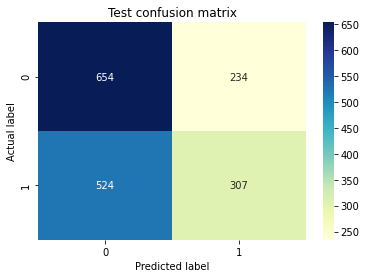

In [29]:
accuracy=accuracy_score(y_test,test_prediction)
print("Test accuracy_score",accuracy)
f1_test_score=f1_score(y_test,test_prediction)
print("Test F1_score",f1_test_score)
print("Test confusion matrix")
cnf_matrix2=confusion_matrix(y_test,test_prediction)
p = sns.heatmap(pd.DataFrame(cnf_matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Test confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

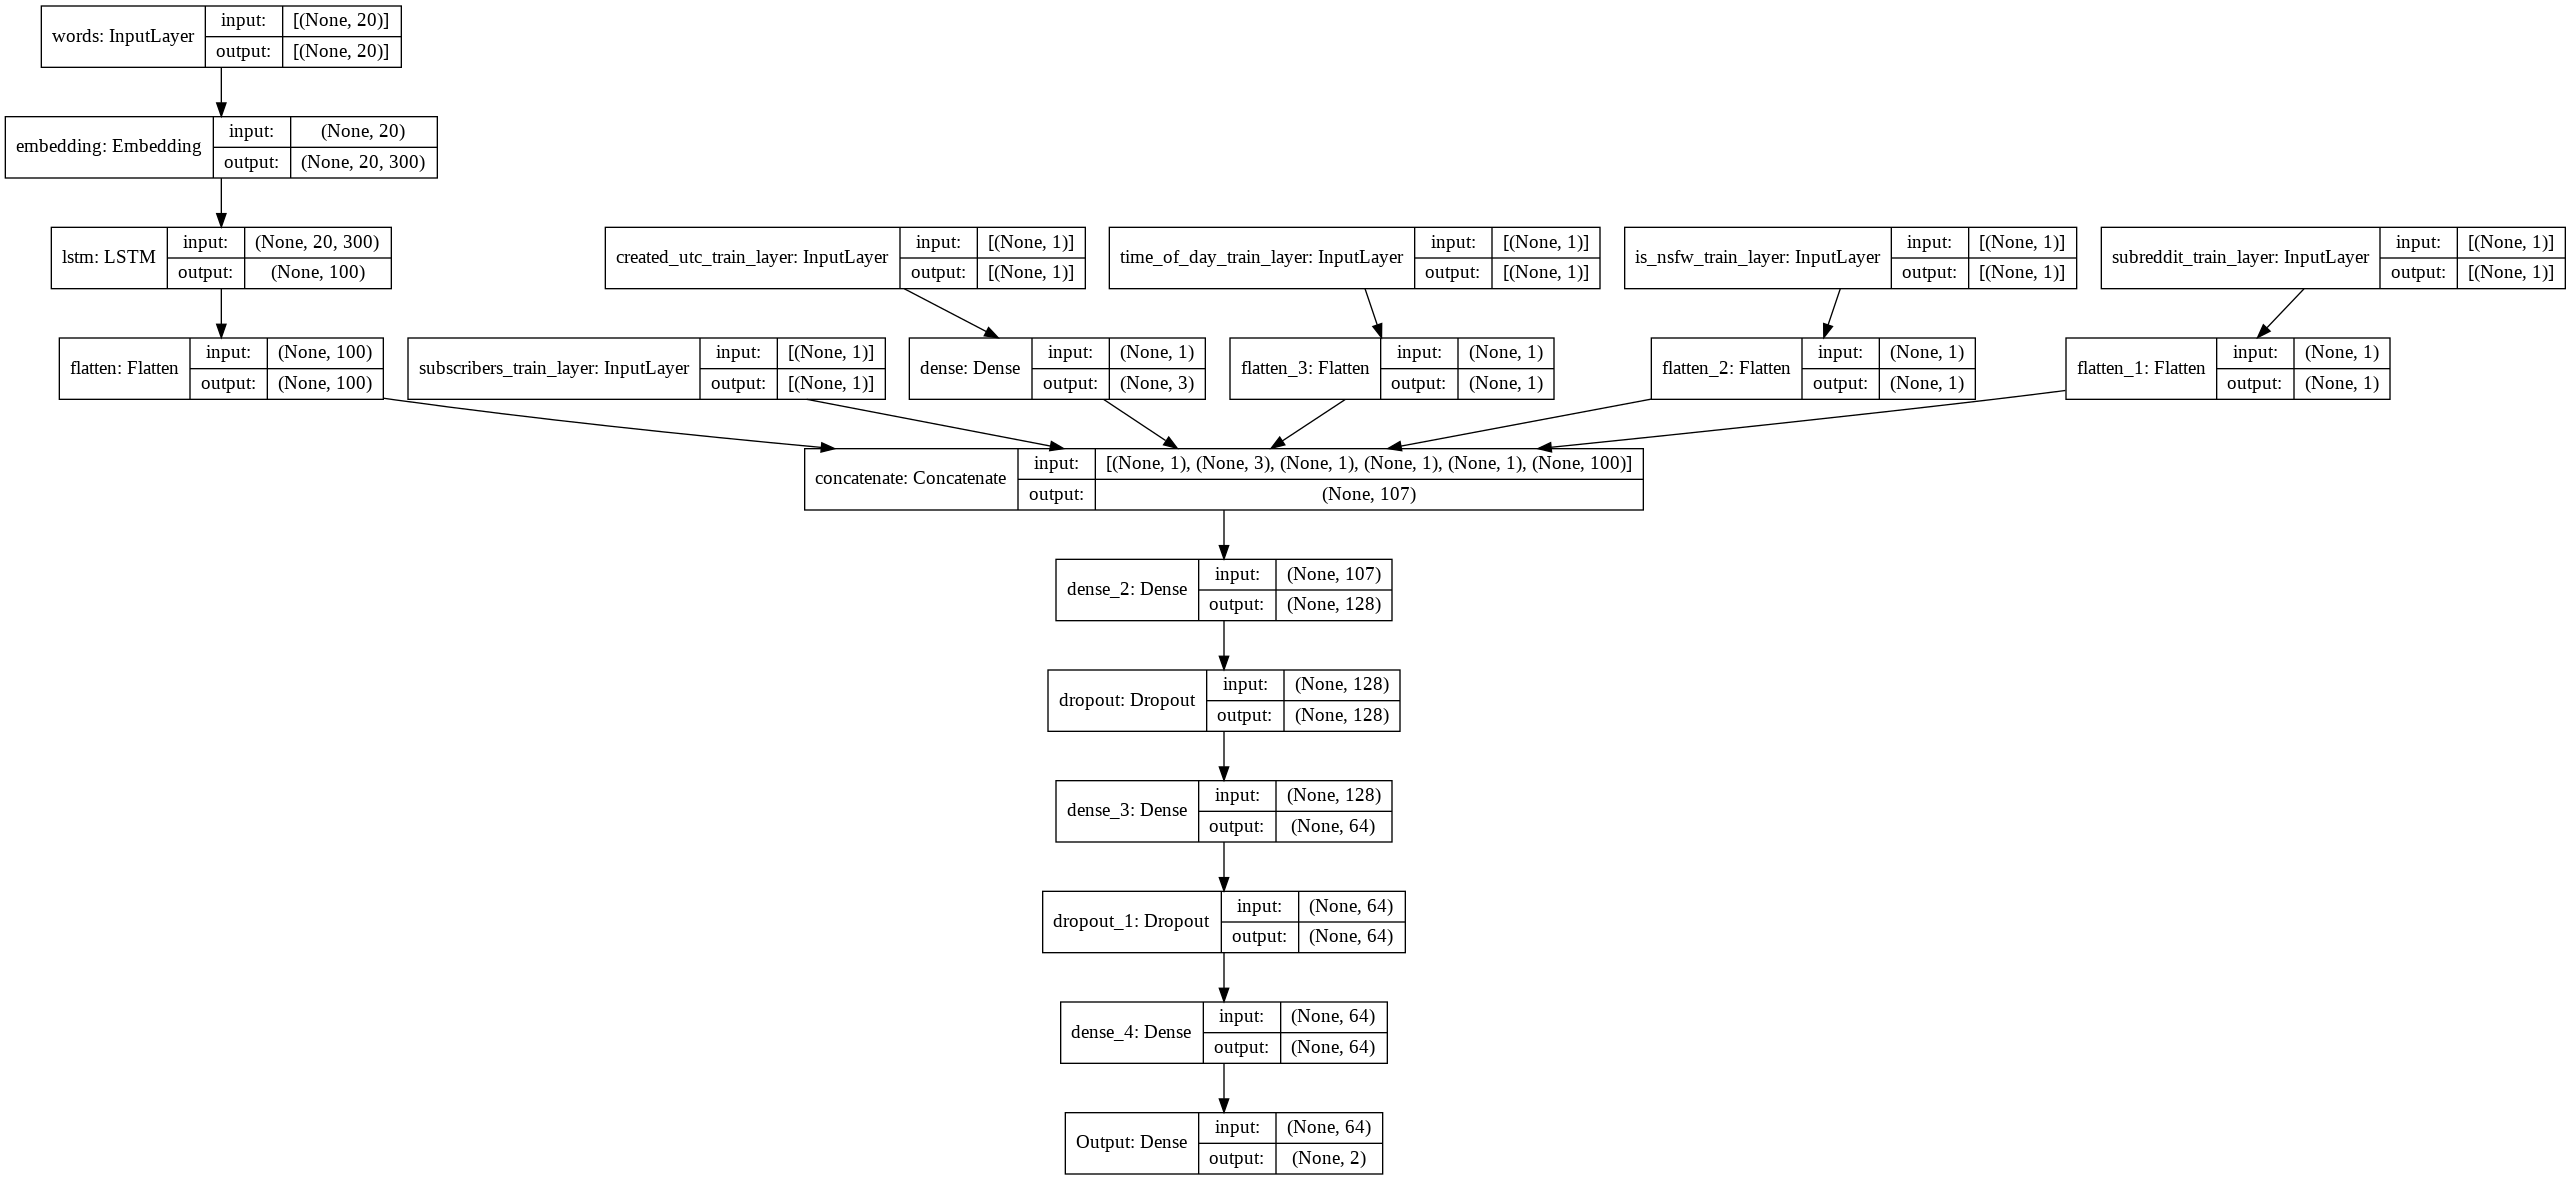

In [27]:
file = '/content/model_1.png'
tf.keras.utils.plot_model(model,to_file=file, show_shapes=True)